In [ ]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
importlib.reload(kgs)
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


local
local


In [ ]:
def to_dict(obj):
    out = dict(obj.__dict__)  # start with stored attributes
    for name in dir(obj):
        if isinstance(getattr(type(obj), name, None), property):
            out[name] = getattr(obj, name)
    return out

@dataclass
class MegaDynamics(kgs.BaseClass):
    # Configuration
    n_trees = 40
    n_ensembles = 1000
    n_rounds = 5
    seed = 42
    plot_interval = None

    # Hyperparameters
    size_setup = 0.5 # will be mulitiplied by sqrt(n_trees)
    duration_init = 10.
    duration_compact = 200.
    duration_final = 10. # careful - lowering this can seem to make things better, but actually can mean overlapping solutions
    dt = 0.02
    friction_min = 0.1
    friction_max = 10.
    friction_periods = 10
    scaling_area_start = 0.3
    scaling_area_end = 0.001
    scaling_boundary = 5.
    scaling_overlap = 1. # recommend to keep this fixed
    scaling_overall_factor = 1.
    use_boundary_distance = True

    # Results
    sizes = None # n_ensemble rows, n_round columns
    best_size = np.inf
    best_xyt = None
    time = None
    xyt_final = None

    def run_simulation(self):
        # Initial configuration
        size_setup_scaled = self.size_setup * np.sqrt(self.n_trees)
        xyt = np.random.default_rng(seed=self.seed).uniform(-0.5, 0.5, size=(self.n_ensembles, self.n_trees, 3))
        xyt = xyt * [[[size_setup_scaled, size_setup_scaled, np.pi]]]
        xyt = np.array(xyt, dtype=np.float32)
        h = np.array([[[2*size_setup_scaled,0.,0.]]*self.n_ensembles], dtype=np.float32)
        print(h.shape)
        cost = pack_cost.CostCompound(costs=[pack_cost.AreaCost(scaling=0.),
                                             pack_cost.BoundaryDistanceCost(scaling=self.scaling_boundary), 
                                             pack_cost.CollisionCostOverlappingArea(scaling=self.scaling_overlap)])
        if not self.use_boundary_distance:
            cost.costs[1] = pack_cost.BoundaryCost(scaling=self.scaling_boundary)


        #plt.ioff()
        if self.plot_interval is not None:
            #plt.ion()
            fig, ax = plt.subplots(figsize=(8, 8))
            tree_list = kgs.TreeList()
            #print(xyt[0].shape)
            #tree_list.xyt = xyt[0]
            #pack_vis.visualize_tree_list(tree_list, ax=ax, h=size_setup_scaled)
            #display(fig)
            #clear_output(wait=True)

        xyt = cp.array(xyt)
        h = cp.array(h)

        t_total = np.float32(0.)
        dt = np.float32(self.dt)
        phase = 'init'
        t_this_phase = np.float32(0.)
        t_last_plot = np.float32(0.)
        rounds_done = 0
        self.sizes = np.zeros((self.n_ensembles, self.n_rounds), dtype=np.float32)
        time_start = time.time()
        velocity_xyt = cp.zeros_like(xyt)
        velocity_h = cp.zeros_like(h)
        while True:            
            if phase == 'compact':
                frac = t_this_phase / self.duration_compact
                start = self.scaling_area_start
                end = self.scaling_area_end
                area_scaling = start * (end / start) ** frac
                cost.costs[0].scaling = area_scaling
                friction = self.friction_max + (self.friction_min - self.friction_max) * (1+np.cos(frac*2*np.pi*self.friction_periods))/2
            else:
                cost.costs[0].scaling = 0.
                friction = 1/dt
            total_cost, total_grad, bound_grad = cost.compute_cost(xyt, h)
            #print(t_total, total_cost)
            total_grad *= self.scaling_overall_factor
            bound_grad *= self.scaling_overall_factor
            velocity_xyt += -dt*friction*velocity_xyt - dt*total_grad
            velocity_h += 0*velocity_h - dt*bound_grad
            xyt += dt * velocity_xyt
            h += dt * velocity_h
            t_total += dt
            t_this_phase += dt
            if self.plot_interval is not None and t_total - t_last_plot >= self.plot_interval*0.999:
                t_last_plot = t_total                
                ax.clear()
                ax.set_aspect('equal', adjustable='box')
                tree_list.xyt = cp.asnumpy(xyt[0])
                pack_vis.visualize_tree_list(tree_list, ax=ax, h=cp.asnumpy(h[0,0]))
                ax.set_title(f'Time: {t_total:.2f}, Round:{rounds_done+1}, Phase: {phase}, Area scaling: {cost.costs[0].scaling:.4f}, Cost: {total_cost[0]:.4f}, friction: {friction}')
                display(fig)
                clear_output(wait=True)       

            if phase == 'init' and t_this_phase >= self.duration_init:
                phase = 'compact'
                t_this_phase = 0.    
            elif phase == 'compact' and t_this_phase >= self.duration_compact:
                phase = 'final'
                t_this_phase = 0.
            elif phase == 'final' and t_this_phase >= self.duration_final:
                # Report out
                self.xyt_final = cp.asnumpy(xyt)
                overlaps = pack_cost.CollisionCostOverlappingArea().compute_cost(sol)[0]
                # Compute edge of smallest axis-aligned square containing all tree polygons for each ensemble
                for ei in range(self.n_ensembles):
                    try:
                        tree_list_local = kgs.TreeList()
                        tree_list_local.xyt = cp.asnumpy(xyt[ei])
                        polygons = tree_list_local.get_trees()
                        # collect all vertex coordinates
                        xs = []
                        ys = []
                        for poly in polygons:
                            for vx, vy in poly.exterior.coords[:-1]:
                                xs.append(vx)
                                ys.append(vy)
                            # include interior rings if present
                            for interior in poly.interiors:
                                for vx, vy in interior.coords[:-1]:
                                    xs.append(vx)
                                    ys.append(vy)
                        min_x = min(xs) if xs else 0.0
                        max_x = max(xs) if xs else 0.0
                        min_y = min(ys) if ys else 0.0
                        max_y = max(ys) if ys else 0.0
                        edge = float(max(max_x - min_x, max_y - min_y))
                        self.sizes[ei, rounds_done] = edge
                    except:
                        self.sizes[ei,rounds_done] = np.nan                    
                    #if overlaps[ei] > 0.0001*np.sqrt(self.n_trees):
                    #    self.sizes[ei, rounds_done] = np.nan
                    if self.sizes[ei, rounds_done] < self.best_size:
                        self.best_size = self.sizes[ei, rounds_done]
                        self.best_xyt = cp.asnumpy(xyt[ei]) 

                rounds_done += 1
                if rounds_done >= self.n_rounds:
                    self.time = time.time()-time_start
                    break
                
                phase = 'compact'
                t_this_phase = 0.   

        # If a temporary plotting figure was created, close it to release resources
        #if self.plot_interval is not None:
        #    plt.close(fig)
            
import pack_dynamics
importlib.reload(pack_dynamics)
                                                       
@dataclass
class MegaDynamics2(pack_dynamics.DynamicsInitialize):
    # Configuration
    n_trees = 40
    n_ensembles = 1000    
    seed = 42
    size_setup = None
   
    # Results
    sizes = None # n_ensemble rows, n_round columns
    best_size = np.inf
    best_xyt = None
    time = None
    xyt_final = None

    def run_simulation_wrap(self):
        # Initial configuration
        size_setup_scaled = self.size_setup * np.sqrt(self.n_trees)
        xyt = np.random.default_rng(seed=self.seed).uniform(-0.5, 0.5, size=(self.n_ensembles, self.n_trees, 3))
        xyt = xyt * [[[size_setup_scaled, size_setup_scaled, np.pi]]]
        xyt = np.array(xyt, dtype=np.float32)
        self.sizes = np.ndarray((self.n_ensembles,))
        h = np.array([[2*size_setup_scaled,0.,0.]]*self.n_ensembles, dtype=np.float32)
        print(h.shape)

        sol = kgs.SolutionCollection()
        sol.xyt= cp.array(xyt)
        sol.h = cp.array(h)

        sol = self.run_simulation(sol)
        xyt,h = sol.xyt, sol.h
        self.xyt_final = xyt
        
        # Report out
        overlaps = pack_cost.CollisionCostOverlappingArea().compute_cost_allocate(sol)[0]
        # Compute edge of smallest axis-aligned square containing all tree polygons for each ensemble
        for ei in range(self.n_ensembles):
            try:
                tree_list_local = kgs.TreeList()
                tree_list_local.xyt = cp.asnumpy(xyt[ei])
                polygons = tree_list_local.get_trees()
                # collect all vertex coordinates
                xs = []
                ys = []
                for poly in polygons:
                    for vx, vy in poly.exterior.coords[:-1]:
                        xs.append(vx)
                        ys.append(vy)
                    # include interior rings if present
                    for interior in poly.interiors:
                        for vx, vy in interior.coords[:-1]:
                            xs.append(vx)
                            ys.append(vy)
                min_x = min(xs) if xs else 0.0
                max_x = max(xs) if xs else 0.0
                min_y = min(ys) if ys else 0.0
                max_y = max(ys) if ys else 0.0
                edge = float(max(max_x - min_x, max_y - min_y))
                self.sizes[ei] = edge
            except:
                self.sizes[ei] = np.nan                    
            #if overlaps[ei] > 0.0001*np.sqrt(self.n_trees):
            #    self.sizes[ei] = np.nan
            if self.sizes[ei] < self.best_size:
                self.best_size = self.sizes[ei]
                self.best_xyt = cp.asnumpy(xyt[ei]) 
                

            
                                                       


local
local


(2, 3)


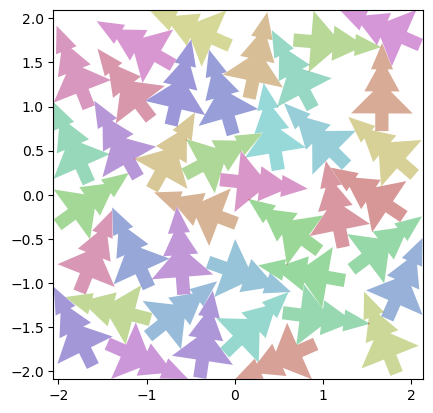

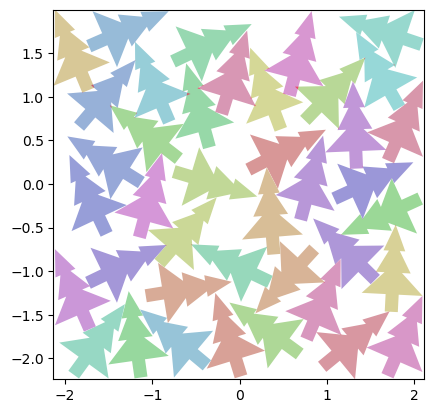

In [9]:
gen = np.random.default_rng(seed=12345)
runner=MegaDynamics2()
runner.n_trees = 40
runner.n_ensembles = 2
runner.n_rounds = 1
runner.plot_interval = None
runner.size_setup = 0.65
runner.duration_init = 10.
runner.duration_compact = 40.
runner.duration_final = 0.
runner.dt = 0.08
runner.scaling_area_start = (10**-0.5)*10.
runner.scaling_area_end = 0.1*10.
runner.scaling_boundary = 5.
runner.scaling_overlap = 10.
#runner.scaling_overall_factor = 10.
runner.use_boundary_distance = True
runner.friction_min = 1.
runner.friction_max = 0.
runner.friction_periods = gen.choice(2)
runner.run_simulation_wrap()
a2 = runner.sizes
xyt_to_relax = runner.xyt_final

relaxer = pack_dynamics.Optimizer()
relaxer.n_iterations *= 4
relaxer.plot_interval = None
sol = kgs.SolutionCollection()
sol.xyt = cp.array(xyt_to_relax, dtype=cp.float32)
sol.snap()
sol=relaxer.run_simulation(sol)
tree_list = kgs.TreeList()
tree_list.xyt = sol.xyt[0].get()
pack_vis.visualize_tree_list(tree_list)
tree_list.xyt = sol.xyt[1].get()
pack_vis.visualize_tree_list(tree_list)

In [ ]:
import pack_ga
importlib.reload(pack_ga)
move = pack_ga.GA().move
generator = np.random.default_rng(seed=12345)
population = pack_ga.Population(configuration=sol)
for _ in range(20):
    pop_here = copy.deepcopy(population)
    move.do_move(pop_here, 0, 1, generator)

stop final relax at some point
